In [1]:
## Imports

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.ticker import MaxNLocator, LogLocator
from matplotlib import cm
import h5py
import os
from mpl_toolkits.mplot3d import axes3d
from cycler import cycler
from scipy.interpolate import griddata
import matplotlib.patches as patches
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
from matplotlib.colors import LinearSegmentedColormap
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

In [2]:
## Helper functions

def CutTimes(time, data, TLow, TUp): ###
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

In [3]:
## Plot constraints

def PlotConstraintViolation(p, spin, figname, norm=True):
    
    levs = ['0','1','2']
    labels = ['Low', 'Med','High']
    def GetFilename(lev):
        return p + '/JoinedSpin' + spin + 'Lev' + lev + '/hConstraints.dat'
    
    fig, ax = plt.subplots(4, sharex=True, figsize=(8,12))
    ## Overall denominator
    Normtime, NormD = np.loadtxt(GetFilename(levs[-1]), comments="#",usecols=([0,5]),unpack=True)
    
    cmap = matplotlib.cm.get_cmap('viridis')
    Colors = [cmap(float(i)/(len(levs))) for i in range(len(levs))]
    Colors = Colors[::-1]
    Linestyles = ['-.', '--', '-']
    
    lw = 3
    ms = 3
    
    for lev, lab, c, ls in zip(levs, labels, Colors, Linestyles):
        time, con1, con3, con2, con4, D = np.loadtxt(GetFilename(lev), \
                                                          comments="#",usecols=([0,1,2,3,4,5]),unpack=True)

        if norm:
            con1 = np.divide(con1, D)
            con2 = np.divide(con2, D)
            con3 = np.divide(con3, D)
            con4 = np.divide(con4, D)
        
        ax[0].plot(time, np.abs(con1), '-', label = lab, c=c, lw=lw, ls=ls)
        ax[1].plot(time, np.abs(con2), '-', label = lab, c=c, lw=lw, ls=ls)
        ax[2].plot(time, np.abs(con3), '-', label = lab, c=c, lw=lw, ls=ls)
        ax[3].plot(time, np.abs(con4), '-', label = lab, c=c, lw=lw, ls=ls)
        
    ax[0].set_ylabel('$\|\Delta C_\mathrm{1}\|/\|N_1\|$')
    ax[1].set_ylabel('$\|\Delta C_\mathrm{2}\|/\|N_2\|$')
    ax[2].set_ylabel('$\|\Delta C_\mathrm{3}\|/\|N_3\|$')
    ax[3].set_ylabel('$\|\Delta C_\mathrm{4}\|/\|N_4\|$')
                                
    for a in ax:
        a.set_yscale('log')
        
    leg = ax[0].legend(fontsize=20,framealpha=1.0, loc='lower left')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
    #ax[-1].set_xlim(0, 0.5)
    ax[-1].set_xlabel('$t/M$')
    plt.subplots_adjust(hspace=0.0)
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()

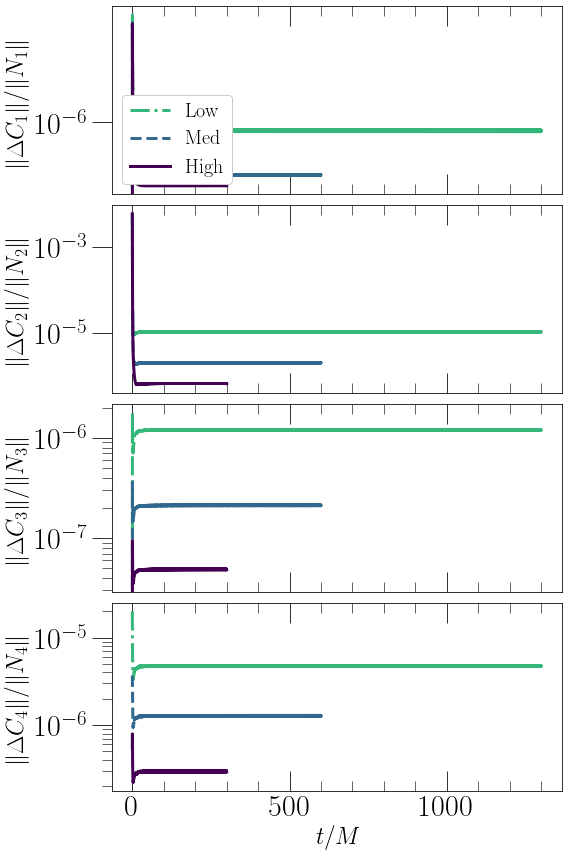

In [35]:
PlotConstraintViolation('Runs_10000', '0.6', 'Test.pdf', norm=True)



In [10]:
## Plot field variables


def PlotVariables(p, spin, figname):
    
    levs = ['0','1','2']
    labels = ['Low', 'Med','High']
    
    def GetFilename(lev):
        return p + '/JoinedSpin' + spin + 'Lev' + lev + '/Vars.dat'
    
    fig, ax = plt.subplots(1, figsize=(8,4))
    
    cmap = matplotlib.cm.get_cmap('magma')
    Colors = [cmap(float(i)/(len(levs))) for i in range(len(levs))]
    Colors = Colors[::-1]
    
    Linestyles = ['-.', '--', '-']
    
    for lev, lab, c, ls in zip(levs, labels, Colors, Linestyles):
        time, psi = np.loadtxt(GetFilename(lev), \
                                                          comments="#",usecols=([0,1]),unpack=True)
        
        #time, psi = CutTimes(time, psi, 25, time[-1])
        ax.plot(time, np.abs(psi), '-', label = lab, c=c, ls=ls)

        
    ax.set_ylabel(r'$\|\Delta g_{ab} \| $')
    leg = ax.legend(fontsize=16,framealpha=1.0, loc='lower center')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    ax.set_xlabel('$t/M$')

    plt.tight_layout()
    plt.savefig(figname)
    plt.show()

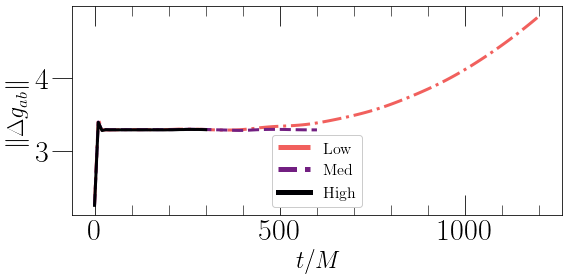

In [11]:
PlotVariables('Runs_Correct', '0.1', 'Test.pdf')
PlotVariables('Runs_Correct', '0.1', 'Test.pdf')




In [6]:
## Plot time derivatives with resolution

def PlotManyVariablesRes(p, spin, figname):
    
    Levs = ['0','1','2']
    Labels = ['Low','Med','High']
    def GetFilename(lev):
        return p + '/JoinedSpin' + spin + 'Lev' + lev + '/Vars.dat'
    
    fig, ax = plt.subplots(1, figsize=(10,8))
    
    cmap = matplotlib.cm.get_cmap('PuBuGn')
    Colors = [cmap(float(i+1)/(len(Levs)+1)) for i in range(len(Levs))]
    Linestyles = ['-', '-', '-']
    
    for lev, lab, c, ls in zip(Levs, Labels, Colors, Linestyles):
        time, psi = np.loadtxt(GetFilename(lev), \
            comments="#",usecols=([0,1]),unpack=True)
        dpsi = np.gradient(psi)/np.gradient(time) #/psi
        ax.plot(time, np.abs(dpsi), '-', label = lab, c=c,lw=2, ls=ls)
        
    ax.set_ylabel(r'$ \partial_t \|\Delta g_{ab}\|$', fontsize=30)
    ax.set_xlabel('$t/M$', fontsize=30)
    A = ax.get_ylim()[1]
    ax.text(100, 0.1*A, r'$\chi = $ ' + spin, fontsize=30)
        
    #ax.axvline(1.2750000000000000e+03)
    ax.set_yscale('log')
    #ax.set_xlim(0,100)
    leg = ax.legend(fontsize=20,framealpha=1.0, loc='best')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()

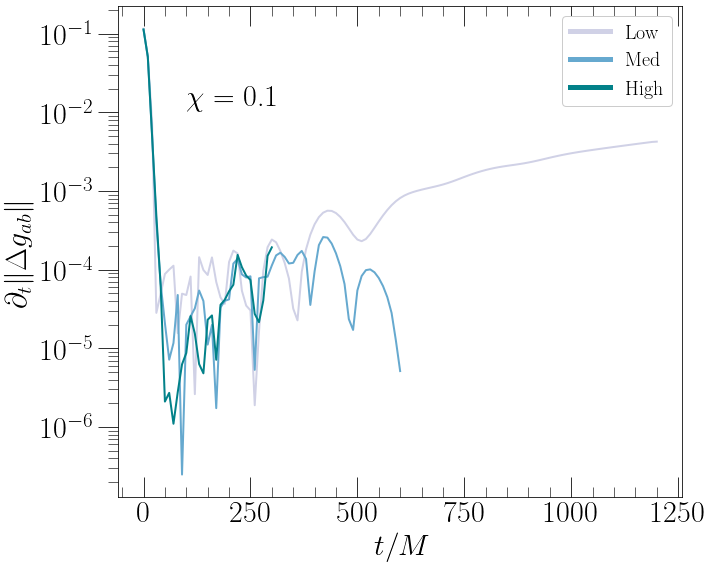

In [7]:
PlotManyVariablesRes('Runs_Correct', '0.1', 'Test.pdf')

In [12]:
## Plot scalar field

def PlotScalarField(p, spin, figname):
    
    levs = ['0','1','2']
    labels = ['Low', 'Med','High']
    
    def GetFilename(lev):
        return p + '/JoinedSpin' + spin + 'Lev' + lev + '/KGVars.dat'
    
    fig, ax = plt.subplots(1, figsize=(8,4))
    
    cmap = matplotlib.cm.get_cmap('magma')
    Colors = [cmap(float(i)/(len(levs))) for i in range(len(levs))]
    Colors = Colors[::-1]
    
    Linestyles = ['-.', '--', '-']
    
    for lev, lab, c, ls in zip(levs, labels, Colors, Linestyles):
        time, psi = np.loadtxt(GetFilename(lev), \
                                                          comments="#",usecols=([0,1]),unpack=True)
        
        #time, KGpsi = CutTimes(time, KGpsi, 25, time[-1])
        ax.plot(time, np.abs(KGpsi), '-', label = lab, c=c, ls=ls)

        
    ax.set_ylabel(r'$\|\Delta \Psi \| $')
    leg = ax.legend(fontsize=16,framealpha=1.0, loc='lower center')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    ax.set_xlabel('$t/M$')

    plt.tight_layout()
    plt.savefig(figname)
    plt.show()

In [ ]:
PlotVariables('Runs_Correct', '0.1', 'Test.pdf')